In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

from models.model_torch import create_model
from data.loader_torch import JetDataset, load_split_from_csv

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import pandas as pd


In [2]:
# === Define all backbone-model_tag pairs to evaluate ===
experiments = [
    {"model_tag": "EfficientNet", "backbone": "efficientnet"},
    {"model_tag": "ConvNeXt", "backbone": "convnext"},
    {"model_tag": "SwinTransformerV2", "backbone": "swin"},
    {"model_tag": "Mamba", "backbone": "mamba"},
    {"model_tag": "VisionMamba", "backbone": "vision_mamba"},
]

In [3]:
model_idx = 0
model_tag = experiments[model_idx]["model_tag"]
backbone = experiments[model_idx]["backbone"]
# ==========================================================
print(f"Evaluating {model_tag} with backbone {backbone}")

Evaluating EfficientNet with backbone efficientnet


In [4]:
# === CONFIG ===

batch_size = 512
epochs = 50
learning_rate = 1e-4
global_max = 121.79151153564453
output_dir = 'training_output/'

In [5]:
import platform
import os
import re
import socket
import getpass

# === Determine platform-specific base path ===
#--- System/User Info ---
system = platform.system()
release = platform.release().lower()
hostname = socket.gethostname().lower()
user = getpass.getuser().lower()

# === Base path detection ===
if system == "Linux" and "wsl" in platform.release().lower() and  "arsalan" in user:
    base_path = "/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data"
    print("[INFO] Detected WSL environment")
elif system == "Linux" and "ds044955" in hostname and "arsalan" in user:
    base_path = "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data"
    print("[INFO] Detected native Ubuntu host: DS044955")
elif system == "Linux" and  "gy4065" in user:
    base_path = "/wsu/home/gy/gy40/gy4065/hm_jetscapeml_source/data"
    print("[INFO] Detected WSU Grid environment (user: gy4065)")
else:
    raise RuntimeError("❌ Unknown system. Please define the dataset path for this host.")

# === Define dataset subdirectory (only this part changes per dataset) ===
dataset_subdir = "jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled"

# === Full dataset path ===
dataset_root_dir = os.path.join(base_path, dataset_subdir)
print(f"[INFO] Using dataset root: {dataset_root_dir}")

# === Extract dataset size from path ===
match = re.search(r"size_(\d+)", dataset_root_dir)
dataset_size = match.group(1) if match else "unknown"
print(f"[INFO] Detected dataset size: {dataset_size}")


[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000


In [6]:
# Build dynamic output directory
run_tag = f"{model_tag}_bs{batch_size}_ep{epochs}_lr{learning_rate:.0e}_ds{dataset_size}"
output_dir = os.path.join(output_dir, run_tag)

os.makedirs(output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {output_dir}")

train_csv = os.path.join(dataset_root_dir, 'train_files.csv')
val_csv = os.path.join(dataset_root_dir, 'val_files.csv')

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000


In [7]:

# Load splits from CSV
train_list = load_split_from_csv(train_csv, dataset_root_dir)
val_list = load_split_from_csv(val_csv, dataset_root_dir)

train_dataset = JetDataset(train_list, global_max=global_max)
val_dataset = JetDataset(val_list, global_max=global_max)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"[INFO] Training samples: {len(train_dataset)}")
print(f"[INFO] Validation samples: {len(val_dataset)}")

#show the length of the dataloaders
print(f"[INFO] Length of training dataloader: {len(train_loader)}")
print(f"[INFO] Length of validation dataloader: {len(val_loader)}")



[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

model, optimizer = create_model(backbone=backbone, input_shape=(1, 32, 32), learning_rate=learning_rate)
model = model.to(device)

criterion = {
    'energy_loss_output': nn.BCELoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(criterion)


[INFO] Using device: cuda
{'energy_loss_output': BCELoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [9]:

def train_one_epoch(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    loss_energy_total = 0.0
    loss_alpha_total = 0.0
    loss_q0_total = 0.0
    
    correct_energy = 0
    correct_alpha = 0
    correct_q0 = 0
    correct_all = 0
    total = 0

    for x, labels in tqdm(loader, desc="Training", leave=False):
        x = x.to(device)
        for key in labels:
            labels[key] = labels[key].to(device)
         # Forward
        outputs = model(x)
        energy_out = outputs['energy_loss_output'].squeeze()
        alpha_out = outputs['alpha_output']
        q0_out = outputs['q0_output']

        # Labels
        gt_energy = labels['energy_loss_output'].squeeze()
        gt_alpha = labels['alpha_output'].squeeze()
        gt_q0 = labels['q0_output'].squeeze()

        # Loss
        loss_energy = criterion['energy_loss_output'](energy_out, gt_energy.float())
        loss_alpha = criterion['alpha_output'](alpha_out, gt_alpha)
        loss_q0 = criterion['q0_output'](q0_out, gt_q0)
        total_batch_loss = loss_energy + loss_alpha + loss_q0
        
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        total_loss += total_batch_loss.item()
        loss_energy_total += loss_energy.item()
        loss_alpha_total += loss_alpha.item()
        loss_q0_total += loss_q0.item()

        # Accuracy
        pred_energy = (energy_out > 0.5).long()
        pred_alpha = torch.argmax(alpha_out, dim=1)
        pred_q0 = torch.argmax(q0_out, dim=1)

        correct_energy += (pred_energy == gt_energy).sum().item()
        correct_alpha += (pred_alpha == gt_alpha).sum().item()
        correct_q0 += (pred_q0 == gt_q0).sum().item()

        correct_all += ((pred_energy == gt_energy) &
                        (pred_alpha == gt_alpha) &
                        (pred_q0 == gt_q0)).sum().item()

        total += x.size(0)

    return {
        'train_loss': total_loss / len(loader),
        'train_loss_energy': loss_energy_total / len(loader),
        'train_loss_alpha': loss_alpha_total / len(loader),
        'train_loss_q0': loss_q0_total / len(loader),
        'train_acc_energy': correct_energy / total,
        'train_acc_alpha': correct_alpha / total,
        'train_acc_q0': correct_q0 / total,
        'train_acc_total': correct_all / total
    }
    

In [10]:
def evaluate(loader, model, criterion, device):
    model.eval()
    y_true = {'energy': [], 'alpha': [], 'q0': []}
    y_pred = {'energy': [], 'alpha': [], 'q0': []}
    correct_all = 0
    total = 0

    val_loss_total = 0.0
    val_loss_energy = 0.0
    val_loss_alpha = 0.0
    val_loss_q0 = 0.0

    with torch.no_grad():
        for x, labels in loader:
            x = x.to(device)
            for key in labels:
                labels[key] = labels[key].to(device)

            outputs = model(x)

            # Energy loss: binary thresholding
            pred_energy = (outputs['energy_loss_output'] > 0.5).long().squeeze()
            pred_alpha = torch.argmax(outputs['alpha_output'], dim=1)
            pred_q0 = torch.argmax(outputs['q0_output'], dim=1)

            gt_energy = labels['energy_loss_output'].squeeze()
            gt_alpha = labels['alpha_output'].squeeze()
            gt_q0 = labels['q0_output'].squeeze()

            y_true['energy'].extend(labels['energy_loss_output'].squeeze().cpu().numpy())
            y_true['alpha'].extend(labels['alpha_output'].squeeze().cpu().numpy())
            y_true['q0'].extend(labels['q0_output'].squeeze().cpu().numpy())

            y_pred['energy'].extend(pred_energy.cpu().numpy())
            y_pred['alpha'].extend(pred_alpha.cpu().numpy())
            y_pred['q0'].extend(pred_q0.cpu().numpy())

            # Total accuracy = all 3 correct
            correct_batch = ((pred_energy == gt_energy) &
                             (pred_alpha == gt_alpha) &
                             (pred_q0 == gt_q0)).sum().item()
            correct_all += correct_batch
            total += x.size(0)

            # Compute loss per task
            energy_out = outputs['energy_loss_output'].squeeze()
            alpha_out = outputs['alpha_output']
            q0_out = outputs['q0_output']

            loss_energy = criterion['energy_loss_output'](energy_out, gt_energy.float())
            loss_alpha = criterion['alpha_output'](alpha_out, gt_alpha)
            loss_q0 = criterion['q0_output'](q0_out, gt_q0)

            val_loss_energy += loss_energy.item()
            val_loss_alpha += loss_alpha.item()
            val_loss_q0 += loss_q0.item()
            val_loss_total += (loss_energy + loss_alpha + loss_q0).item()

            
    # Compute individual accuracies
    acc_total = correct_all / total
    avg_loss_energy = val_loss_energy / len(loader)
    avg_loss_alpha = val_loss_alpha / len(loader)
    avg_loss_q0 = val_loss_q0 / len(loader)
    avg_val_loss = val_loss_total / len(loader)
    
    # All metrics + losses in one dict
    metrics = {
        "total_accuracy": acc_total,
        "val_loss": avg_val_loss,
        "val_loss_energy": avg_loss_energy,
        "val_loss_alpha": avg_loss_alpha,
        "val_loss_q0": avg_loss_q0,
        "energy": {
            "accuracy": accuracy_score(y_true['energy'], y_pred['energy']),
            "precision": precision_score(y_true['energy'], y_pred['energy'], average='macro'),
            "recall": recall_score(y_true['energy'], y_pred['energy'], average='macro'),
            "f1": f1_score(y_true['energy'], y_pred['energy'], average='macro'),
        },
        "alpha": {
            "accuracy": accuracy_score(y_true['alpha'], y_pred['alpha']),
            "precision": precision_score(y_true['alpha'], y_pred['alpha'], average='macro'),
            "recall": recall_score(y_true['alpha'], y_pred['alpha'], average='macro'),
            "f1": f1_score(y_true['alpha'], y_pred['alpha'], average='macro'),
        },
        "q0": {
            "accuracy": accuracy_score(y_true['q0'], y_pred['q0']),
            "precision": precision_score(y_true['q0'], y_pred['q0'], average='macro'),
            "recall": recall_score(y_true['q0'], y_pred['q0'], average='macro'),
            "f1": f1_score(y_true['q0'], y_pred['q0'], average='macro'),
        }
    }

    return metrics


In [11]:
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_losses = [], [], [],[]
train_energy_acc_list, train_alpha_acc_list, train_q0_acc_list, train_total_acc_list = [], [], [], []


val_losses,val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list = [], [], [], []
acc_energy_list, acc_alpha_list,acc_q0_list ,acc_total_list = [],[],[],[]


all_epoch_metrics = []

In [12]:
import json
import datetime, json

summary_path = os.path.join(output_dir, "training_summary.json")
resume_path = os.path.join(output_dir, "best_model.pth")
best_model_path = os.path.join(output_dir, f"best_model.pth")

patience = 5
best_epoch = 0
start_epoch = 0
best_total_acc = 0.0
early_stop_counter = 0

best_metrics = {}
training_summary= {}

# Try loading resume state
if os.path.exists(resume_path) and os.path.exists(summary_path):
    print(f"🔁 Resuming training from checkpoint and summary")
    
    # Load model checkpoint
    checkpoint = torch.load(resume_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_total_acc = checkpoint.get('acc_total', 0.0)
    best_metrics = checkpoint.get('metrics', {})

    # Load summary info (optional counters/history)
    with open(summary_path, "r") as f:
        summary_data = json.load(f)
        early_stop_counter = summary_data.get("early_stop_counter", 0)
        acc_energy_list = summary_data.get("acc_energy_list", [])
        acc_alpha_list = summary_data.get("acc_alpha_list", [])
        acc_q0_list = summary_data.get("acc_q0_list", [])
        acc_total_list = summary_data.get("acc_total_list", [])
        all_epoch_metrics = summary_data.get("all_epoch_metrics", [])

    print(f"[INFO] Resumed at epoch {start_epoch} with total acc {best_total_acc:.4f} and early stop counter {early_stop_counter}")
else:
    print(f"[INFO] Starting fresh training run")
    
    # Initial summary structure
    training_summary = {
        "model_tag": model_tag,
        "backbone": backbone,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "dataset_root": dataset_root_dir,
        "global_max": global_max,
        "start_time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "status": "interrupted_or_incomplete"
    }

    # Save the early config snapshot
    summary_path = os.path.join(output_dir, "training_summary.json")
    with open(summary_path, "w") as f:
        json.dump(training_summary, f, indent=2)

    print(f"[INFO] Initial training summary saved at: {summary_path}")
    


[INFO] Starting fresh training run
[INFO] Initial training summary saved at: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/training_summary.json


In [13]:

for epoch in range(start_epoch, epochs):

    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)

    # Save metrics
    
    train_energy_acc_list.append(train_metrics['train_acc_energy'])
    train_alpha_acc_list.append(train_metrics['train_acc_alpha'])
    train_q0_acc_list.append(train_metrics['train_acc_q0'])
    train_total_acc_list.append(train_metrics['train_acc_total'])

    train_loss_energy_list.append(train_metrics['train_loss_energy'])
    train_loss_alpha_list.append(train_metrics['train_loss_alpha'])
    train_loss_q0_list.append(train_metrics['train_loss_q0'])
    train_losses.append(train_metrics['train_loss'])
    

    print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {train_metrics['train_acc_total']:.4f} - Train Loss: {train_metrics['train_loss']:.4f}")

    # metrics, acc_total = evaluate(val_loader, model, device)
    metrics = evaluate(val_loader, model, criterion, device)

    acc_total = metrics["total_accuracy"]
    
    acc_energy_list.append(metrics['energy']['accuracy'])
    acc_alpha_list.append(metrics['alpha']['accuracy'])
    acc_q0_list.append(metrics['q0']['accuracy'])
    acc_total_list.append(acc_total)
    

    val_loss = metrics["val_loss"]
    val_loss_energy = metrics["val_loss_energy"]
    val_loss_alpha = metrics["val_loss_alpha"]
    val_loss_q0 = metrics["val_loss_q0"]
    val_losses.append(val_loss)
    val_loss_energy_list.append(val_loss_energy)
    val_loss_alpha_list.append(val_loss_alpha)
    val_loss_q0_list.append(val_loss_q0)

    
    import datetime
    print("="*epochs)
    print(f"Epoch {epoch+1}: Energy Acc ={metrics['energy']['accuracy']:.4f}, αs Acc = {metrics['alpha']['accuracy']:.4f}, Q0 Acc = {metrics['q0']['accuracy']:.4f}, Total Acc = {acc_total:.4f}")
    if acc_total > best_total_acc:
        best_total_acc = acc_total
        best_metrics = metrics
        best_epoch = epoch + 1
        early_stop_counter = 0  # reset counter

        # Save best model
        best_model_path = os.path.join(output_dir, "best_model.pth")
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': best_metrics,
            'acc_total': acc_total,
            'backbone': backbone,
            'input_shape': (1, 32, 32),
        }, best_model_path)

        print(f"✅ Best model saved at epoch {best_epoch} with total accuracy: {acc_total:.4f}")
    else:
        early_stop_counter += 1
        print(f"⏳ No improvement. Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}. Best was at epoch {best_epoch}.")
            break
        
    # print(f"✅ Best model saved with total accuracy: {acc_total:.4f}")
    print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Epoch {epoch+1}/{epochs} - Train Loss: {train_metrics['train_loss']:.4f}")
    epoch_record = {
    "epoch": epoch + 1,

    # Train losses
    "train_loss": train_metrics["train_loss"],
    "train_loss_energy": train_metrics["train_loss_energy"],
    "train_loss_alpha": train_metrics["train_loss_alpha"],
    "train_loss_q0": train_metrics["train_loss_q0"],

    # Train accuracies
    "train_acc_energy": train_metrics["train_acc_energy"],
    "train_acc_alpha": train_metrics["train_acc_alpha"],
    "train_acc_q0": train_metrics["train_acc_q0"],
    "train_acc_total": train_metrics["train_acc_total"],

    # Validation loss (from metrics)
    "val_loss": metrics["val_loss"],
    "val_loss_energy": metrics["val_loss_energy"],
    "val_loss_alpha": metrics["val_loss_alpha"],
    "val_loss_q0": metrics["val_loss_q0"],

    # Validation metrics
    "val_total_accuracy": metrics["total_accuracy"],
    "val_energy": metrics["energy"],
    "val_alpha": metrics["alpha"],
    "val_q0": metrics["q0"],
}
    all_epoch_metrics.append(epoch_record)
    
    with open(os.path.join(output_dir, "epoch_metrics.json"), "w") as f:
        json.dump(all_epoch_metrics, f, indent=2)
    

    df = pd.DataFrame([
        {
            'epoch': m['epoch'],

            # Train loss and accuracy
            'train_loss': m['train_loss'],
            'train_loss_energy': m['train_loss_energy'],
            'train_loss_alpha': m['train_loss_alpha'],
            'train_loss_q0': m['train_loss_q0'],

            'train_acc_energy': m['train_acc_energy'],
            'train_acc_alpha': m['train_acc_alpha'],
            'train_acc_q0': m['train_acc_q0'],
            'train_acc_total': m['train_acc_total'],

            # === Validation losses and accuracy ===
            'val_loss': m['val_loss'],
            'val_loss_energy': m['val_loss_energy'],
            'val_loss_alpha': m['val_loss_alpha'],
            'val_loss_q0': m['val_loss_q0'],

            # Val loss and total acc
            'val_total_acc': m['val_total_accuracy'],

            # Validation metrics (flattened)
            'val_energy_acc': m['val_energy']['accuracy'],
            'val_energy_prec': m['val_energy']['precision'],
            'val_energy_rec': m['val_energy']['recall'],
            'val_energy_f1': m['val_energy']['f1'],

            'val_alpha_acc': m['val_alpha']['accuracy'],
            'val_alpha_prec': m['val_alpha']['precision'],
            'val_alpha_rec': m['val_alpha']['recall'],
            'val_alpha_f1': m['val_alpha']['f1'],

            'val_q0_acc': m['val_q0']['accuracy'],
            'val_q0_prec': m['val_q0']['precision'],
            'val_q0_rec': m['val_q0']['recall'],
            'val_q0_f1': m['val_q0']['f1'],
        
        }
        for m in all_epoch_metrics
    ])
    df.to_csv(os.path.join(output_dir, "epoch_metrics.csv"), index=False)

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'acc_total': acc_total,
        'metrics': metrics,
    }, os.path.join(output_dir, f"checkpoint_epoch_{epoch+1}.pth"))

/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/50 - Train Accuracy: 0.0616 - Train Loss: 3.1927
Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
✅ Best model saved at epoch 1 with total accuracy: 0.0833
[13:02:33] Epoch 1/50 - Train Loss: 3.1927


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 2/50 - Train Accuracy: 0.0666 - Train Loss: 3.1665
Epoch 2: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
⏳ No improvement. Early stop counter: 1/5
[13:02:37] Epoch 2/50 - Train Loss: 3.1665


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 3/50 - Train Accuracy: 0.0942 - Train Loss: 3.1348
Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
⏳ No improvement. Early stop counter: 2/5
[13:02:42] Epoch 3/50 - Train Loss: 3.1348


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 4/50 - Train Accuracy: 0.0842 - Train Loss: 3.1345
Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
⏳ No improvement. Early stop counter: 3/5
[13:02:46] Epoch 4/50 - Train Loss: 3.1345


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 5/50 - Train Accuracy: 0.0905 - Train Loss: 3.1173
Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
⏳ No improvement. Early stop counter: 4/5
[13:02:51] Epoch 5/50 - Train Loss: 3.1173


Epoch 6/50 - Train Accuracy: 0.0955 - Train Loss: 3.1144
Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered at epoch 6. Best was at epoch 1.


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [14]:
# Update and finalize the training summary
training_summary.update({
    "best_epoch": best_epoch,
    "best_total_accuracy": best_total_acc,
    "end_time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "status": "completed",
    "best_model_path": os.path.abspath(os.path.join(output_dir, "best_model.pth")),
    "metrics_file": os.path.abspath(os.path.join(output_dir, "best_model_metrics.json")),
    "epoch_metrics_csv": os.path.abspath(os.path.join(output_dir, "epoch_metrics.csv")),
    "epoch_metrics_json": os.path.abspath(os.path.join(output_dir, "epoch_metrics.json"))
})

# Overwrite with final summary
with open(summary_path, "w") as f:
    json.dump(training_summary, f, indent=2)

print(f"✅ Final training summary updated and saved to: {summary_path}")

✅ Final training summary updated and saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/training_summary.json


In [15]:
print(f"\n🏁 Best Model @ Epoch {best_epoch}")
print(f"Total Accuracy: {best_total_acc:.4f}")
for task in ['energy', 'alpha', 'q0']:
    print(f"\n🔹 {task.upper()} Task")
    print(f"  Accuracy : {best_metrics[task]['accuracy']:.4f}")
    print(f"  Precision: {best_metrics[task]['precision']:.4f}")
    print(f"  Recall   : {best_metrics[task]['recall']:.4f}")
    print(f"  F1-Score : {best_metrics[task]['f1']:.4f}")
print(f"Saved to: {best_model_path}")


🏁 Best Model @ Epoch 1
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000
Saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/best_model.pth


📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/train_loss_acc_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/train_loss_acc_plot.pdf


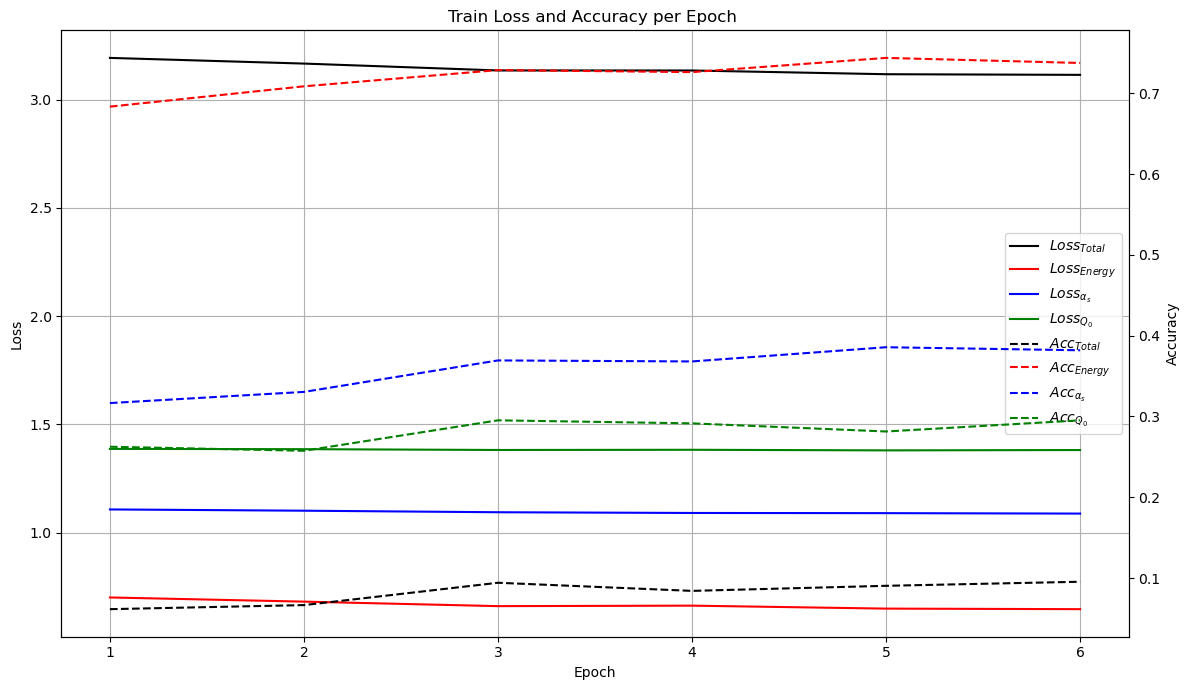

In [16]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_losses) + 1)

# Define shared colors for each task
colors = {
    "total": "black",
    "energy": "red",
    "alpha": "blue",
    "q0": "green",
}

fig, ax1 = plt.subplots(figsize=(12, 7))

# === Plot Losses (solid lines) ===
ax1.plot(epochs, train_losses, label="$Loss_{Total}$", color=colors["total"], linestyle='-')
ax1.plot(epochs, train_loss_energy_list, label="$Loss_{Energy}$", color=colors["energy"], linestyle='-')
ax1.plot(epochs, train_loss_alpha_list, label="$Loss_{{\\alpha}_s}$", color=colors["alpha"], linestyle='-')
ax1.plot(epochs, train_loss_q0_list, label="$Loss_{Q_0}$", color=colors["q0"], linestyle='-')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

# === Plot Accuracies (dashed lines) ===
ax2 = ax1.twinx()
ax2.plot(epochs, train_total_acc_list, label="$Acc_{Total}$", color=colors["total"], linestyle='--')
ax2.plot(epochs, train_energy_acc_list, label="$Acc_{Energy}$", color=colors["energy"], linestyle='--')
ax2.plot(epochs, train_alpha_acc_list, label="$Acc_{{\\alpha}_s}$", color=colors["alpha"], linestyle='--')
ax2.plot(epochs, train_q0_acc_list, label="$Acc_{Q_0}$", color=colors["q0"], linestyle='--')
ax2.set_ylabel("Accuracy")

# Axis labels and title
ax1.set_title("Train Loss and Accuracy per Epoch ")
ax1.grid(True)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.tight_layout()

# Save loss plot
train_loss_acc_path_png = os.path.join(output_dir, "train_loss_acc_plot.png")
train_loss_acc_path_pdf = os.path.join(output_dir, "train_loss_acc_plot.pdf")

plt.savefig(train_loss_acc_path_png, dpi=300, bbox_inches='tight')
plt.savefig(train_loss_acc_path_pdf, bbox_inches='tight')

print(f"📉 Loss plot saved as:\n  - {train_loss_acc_path_png}\n  - {train_loss_acc_path_pdf}")

plt.show()


📉 Validation plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/val_loss_acc_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/val_loss_acc_plot.pdf


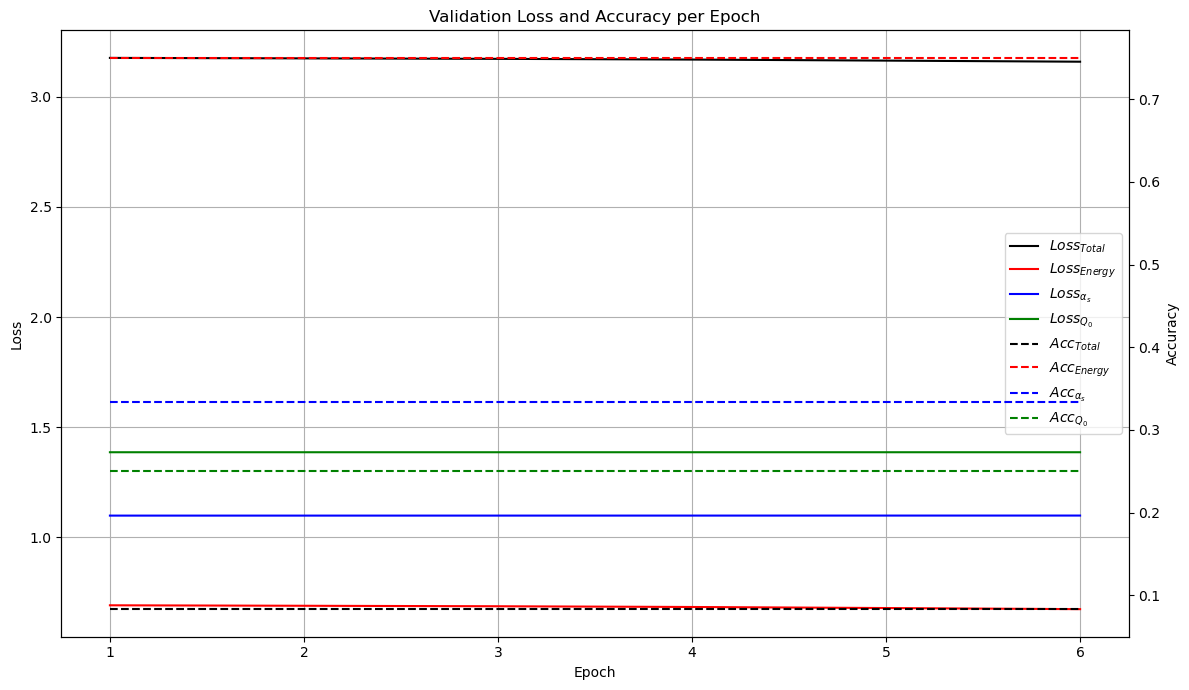

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(val_losses) + 1)

# Define shared colors for each task
colors = {
    "total": "black",
    "energy": "red",
    "alpha": "blue",
    "q0": "green",
}

fig, ax1 = plt.subplots(figsize=(12, 7))

# === Plot Validation Losses (solid lines) ===
ax1.plot(epochs, val_losses, label="$Loss_{Total}$", color=colors["total"], linestyle='-')
ax1.plot(epochs, val_loss_energy_list, label="$Loss_{Energy}$", color=colors["energy"], linestyle='-')
ax1.plot(epochs, val_loss_alpha_list, label="$Loss_{{\\alpha}_s}$", color=colors["alpha"], linestyle='-')
ax1.plot(epochs, val_loss_q0_list, label="$Loss_{Q_0}$", color=colors["q0"], linestyle='-')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

# === Plot Validation Accuracies (dashed lines) ===
ax2 = ax1.twinx()
ax2.plot(epochs, acc_total_list, label="$Acc_{Total}$", color=colors["total"], linestyle='--')
ax2.plot(epochs, acc_energy_list, label="$Acc_{Energy}$", color=colors["energy"], linestyle='--')
ax2.plot(epochs, acc_alpha_list, label="$Acc_{{\\alpha}_s}$", color=colors["alpha"], linestyle='--')
ax2.plot(epochs, acc_q0_list, label="$Acc_{Q_0}$", color=colors["q0"], linestyle='--')
ax2.set_ylabel("Accuracy")

# Axis labels and title
ax1.set_title("Validation Loss and Accuracy per Epoch")
ax1.grid(True)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.tight_layout()

# Save plots
val_loss_acc_path_png = os.path.join(output_dir, "val_loss_acc_plot.png")
val_loss_acc_path_pdf = os.path.join(output_dir, "val_loss_acc_plot.pdf")

plt.savefig(val_loss_acc_path_png, dpi=300, bbox_inches='tight')
plt.savefig(val_loss_acc_path_pdf, bbox_inches='tight')

print(f"📉 Validation plot saved as:\n  - {val_loss_acc_path_png}\n  - {val_loss_acc_path_pdf}")

plt.show()


In [18]:
import torch
from models.model_torch import create_model

# Load checkpoint
checkpoint = torch.load(best_model_path
, map_location=torch.device('cpu'))

# Recreate model using saved params
model, _ = create_model(
    backbone=checkpoint['backbone'],
    input_shape=checkpoint['input_shape'],
    learning_rate=1e-4  # not used when reloading
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded from epoch {checkpoint['epoch']} with Total Accuracy: {checkpoint['acc_total']:.4f}")


/tmp/ipykernel_26665/98680750.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path


✅ Model loaded from epoch 1 with Total Accuracy: 0.0833


In [ ]:
print(f"[INFO] Saving best metrics to {os.path.join(output_dir, 'best_model_metrics.json')}")

import json
with open(os.path.join(output_dir, "best_model_metrics.json")
, "w") as f:
    json.dump(checkpoint['metrics'], f, indent=2)